# House Prices - Advanced Regression Techniques
#### Author: James Coffey
#### Date: 5/22/2025
#### Challenge URL: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

# Business Understanding

> **Goal:** Align on the problem, success metrics, and constraints before touching any data.

* **What** exactly is the business question or problem we’re solving?
* **Who** are the stakeholders and end-users, and what decisions will they make from our work?
* **How** will success be measured (revenue lift, error reduction, user engagement, etc.)?
* **What** are the timeline, budget, technical or regulatory constraints?

# Data Acquisition

> **Goal:** Identify, access, and gather all relevant raw data.

* **Which** data sources—databases, APIs, third-party feeds, flat files, user logs—are needed?
* **Is** the historical coverage and granularity sufficient for modeling?
* **How** do we authenticate, extract, and securely store that data?
* **What** metadata (schema definitions, data dictionaries) do we need to collect as well?

# Imports & Settings

In [ ]:
%%capture

import math
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
import ydf
from optuna.pruners import HyperbandPruner
from optuna.samplers import GridSampler, RandomSampler
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error

from src.house_prices.featureize import make_preprocessor

from src.house_prices.train import (
    make_cart_objective,
    make_gbts_objective,
    make_mlp_objective,
    make_rf_objective,
    make_xgb_objective,
)

# Comment this if the data visualisations do not work
%matplotlib inline

# Keep the notebook clean
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # only ERROR and above
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore",
    category=ConvergenceWarning,
    module="sklearn.linear_model._coordinate_descent"
)
optuna.logging.set_verbosity(optuna.logging.ERROR)
tf.get_logger().setLevel('ERROR')
save_verbose = ydf.verbose(0)

# Use IS_INTERACTIVE to flag models / code not to run for Kaggle submission
IS_INTERACTIVE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") == "Interactive"

2025-05-24 21:19:13.342329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748121553.364305     162 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748121553.371165     162 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Ingestion & Loading

> **Goal:** Bring raw data into your working environment in a consistent, queryable form.

* **What** formats (CSV, JSON, Parquet, SQL tables) and partitioning schemes will you use?
* **How** will you version and document each data snapshot?
* **Are** there schema mismatches or encoding issues to resolve on ingestion?

In [ ]:
base_path = "/kaggle/input/house-prices-advanced-regression-techniques"
train = pd.read_csv(f"{base_path}/train.csv")

## Glance at the dataset description

<details>
<summary><strong>MSSubClass</strong>: Identifies the type of dwelling involved in the sale.</summary>

| Code | Description                               |
| ---- | ----------------------------------------- |
| 20   | 1-STORY 1946 & NEWER ALL STYLES           |
| 30   | 1-STORY 1945 & OLDER                      |
| 40   | 1-STORY W/FINISHED ATTIC ALL AGES         |
| 45   | 1-1/2 STORY – UNFINISHED ALL AGES         |
| 50   | 1-1/2 STORY FINISHED ALL AGES             |
| 60   | 2-STORY 1946 & NEWER                      |
| 70   | 2-STORY 1945 & OLDER                      |
| 75   | 2-1/2 STORY ALL AGES                      |
| 80   | SPLIT OR MULTI-LEVEL                      |
| 85   | SPLIT FOYER                               |
| 90   | DUPLEX – ALL STYLES AND AGES              |
| 120  | 1-STORY PUD – 1946 & NEWER                |
| 150  | 1-1/2 STORY PUD – ALL AGES                |
| 160  | 2-STORY PUD – 1946 & NEWER                |
| 180  | PUD – MULTILEVEL – INCL SPLIT LEV/FOYER   |
| 190  | 2 FAMILY CONVERSION – ALL STYLES AND AGES |
</details>
<details>
<summary><strong>MSZoning</strong>: Identifies the general zoning classification of the sale.</summary>

| Code | Description                  |
| ---- | ---------------------------- |
| A    | Agriculture                  |
| C    | Commercial                   |
| FV   | Floating Village Residential |
| I    | Industrial                   |
| RH   | Residential High Density     |
| RL   | Residential Low Density      |
| RP   | Residential Low Density Park |
| RM   | Residential Medium Density   |
</details>

**LotFrontage**: Linear feet of street connected to property

**LotArea**: Lot size in square feet

<details>
<summary><strong>Street</strong>: Type of road access to property.</summary>

| Code | Description |
| ---- | ----------- |
| Grvl | Gravel      |
| Pave | Paved       |
</details>
<details>
<summary><strong>Alley</strong>: Type of alley access to property.</summary>

| Code | Description     |
| ---- | --------------- |
| Grvl | Gravel          |
| Pave | Paved           |
| NA   | No alley access |
</details>
<details>
<summary><strong>LotShape</strong>: General shape of property.</summary>

| Code | Description          |
| ---- | -------------------- |
| Reg  | Regular              |
| IR1  | Slightly irregular   |
| IR2  | Moderately irregular |
| IR3  | Irregular            |
</details>
<details>
<summary><strong>LandContour</strong>: Flatness of the property.</summary>

| Code | Description                                       |
| ---- | ------------------------------------------------- |
| Lvl  | Near Flat/Level                                   |
| Bnk  | Banked – Quick rise from street grade to building |
| HLS  | Hillside – Significant slope from side to side    |
| Low  | Depression                                        |
</details>
<details>
<summary><strong>Utilities</strong>: Type of utilities available.</summary>

| Code   | Description                            |
| ------ | -------------------------------------- |
| AllPub | All public utilities (E, G, W & S)     |
| NoSeWa | Electricity and Gas only               |
| NoSewr | Electricity, Gas & Water (Septic Tank) |
| ELO    | Electricity only                       |
</details>
<details>
<summary><strong>LotConfig</strong>: Lot configuration.</summary>

| Code    | Description                     |
| ------- | ------------------------------- |
| Inside  | Inside lot                      |
| Corner  | Corner lot                      |
| CulDSac | Cul-de-sac                      |
| FR2     | Frontage on 2 sides of property |
| FR3     | Frontage on 3 sides             |
</details>
<details>
<summary><strong>LandSlope</strong>: Slope of property.</summary>

| Code | Description    |
| ---- | -------------- |
| Gtl  | Gentle slope   |
| Mod  | Moderate slope |
| Sev  | Severe slope   |
</details>
<details>
<summary><strong>Neighborhood</strong>: Physical locations within Ames city limits.</summary>

| Code    | Description         |
| ------- | ------------------- |
| Blmngtn | Bloomington Heights |
| Blueste | Bluestem            |
| BrDale  | Briardale           |
| BrkSide | Brookside           |
| ClearCr | Clear Creek         |
| CollgCr | College Creek       |
| Crawfor | Crawford            |
| Edwards | Edwards             |
| Gilbert | Gilbert             |
| IDOTRR  | Iowa DOT & Railroad |
| MeadowV | Meadow Village      |
| Mitchel | Mitchell            |
| NAmes   | North Ames          |
| NPkVill | Northpark Villa     |
| NWAmes  | Northwest Ames      |
| NoRidge | Northridge          |
| NridgHt | Northridge Heights  |
| OldTown | Old Town            |
| SWISU   | S & W of ISU        |
| Sawyer  | Sawyer              |
| SawyerW | West of Sawyer      |
| Somerst | Somerset            |
| StoneBr | Stone Brook         |
| Timber  | Timberland          |
| Veenker | Veenker             |
</details>
<details>
<summary><strong>Condition1</strong>: Proximity to various conditions.</summary>

| Code   | Description                                      |
| ------ | ------------------------------------------------ |
| Artery | Adjacent to arterial street                      |
| Feedr  | Adjacent to feeder street                        |
| Norm   | Normal                                           |
| RRNn   | Within 200' of N–S railroad                      |
| RRAn   | Adjacent to N–S railroad                         |
| RRNe   | Within 200' of E–W railroad                      |
| RRAe   | Adjacent to E–W railroad                         |
| PosN   | Near positive off-site feature (park, greenbelt) |
| PosA   | Adjacent to positive off-site feature            |
</details>
<details>
<summary><strong>Condition2</strong>: Proximity to various conditions (if more than one).</summary>

| Code   | Description                                      |
| ------ | ------------------------------------------------ |
| Artery | Adjacent to arterial street                      |
| Feedr  | Adjacent to feeder street                        |
| Norm   | Normal                                           |
| RRNn   | Within 200' of N–S railroad                      |
| RRAn   | Adjacent to N–S railroad                         |
| RRNe   | Within 200' of E–W railroad                      |
| RRAe   | Adjacent to E–W railroad                         |
| PosN   | Near positive off-site feature (park, greenbelt) |
| PosA   | Adjacent to positive off-site feature            |
</details>
<details>
<summary><strong>BldgType</strong>: Type of dwelling.</summary>

| Code   | Description                                   |
| ------ | --------------------------------------------- |
| 1Fam   | Single-family Detached                        |
| 2FmCon | Two-family Conversion (originally one-family) |
| Duplex | Duplex                                        |
| TwnhsE | Townhouse End Unit                            |
| TwnhsI | Townhouse Inside Unit                         |
</details>
<details>
<summary><strong>HouseStyle</strong>: Style of dwelling.</summary>

| Code   | Description                                   |
| ------ | --------------------------------------------- |
| 1Story | One story                                     |
| 1.5Fin | One and one-half story (2nd level finished)   |
| 1.5Unf | One and one-half story (2nd level unfinished) |
| 2Story | Two story                                     |
| 2.5Fin | Two and one-half story (finished)             |
| 2.5Unf | Two and one-half story (unfinished)           |
| SFoyer | Split foyer                                   |
| SLvl   | Split level                                   |
</details>
<details>
<summary><strong>OverallQual</strong>: Rates the overall material and finish quality.</summary>

| Code | Rating         |
| ---- | -------------- |
| 10   | Very Excellent |
| 9    | Excellent      |
| 8    | Very Good      |
| 7    | Good           |
| 6    | Above Average  |
| 5    | Average        |
| 4    | Below Average  |
| 3    | Fair           |
| 2    | Poor           |
| 1    | Very Poor      |
</details>
<details>
<summary><strong>OverallCond</strong>: Rates the overall condition.</summary>

| Code | Rating         |
| ---- | -------------- |
| 10   | Very Excellent |
| 9    | Excellent      |
| 8    | Very Good      |
| 7    | Good           |
| 6    | Above Average  |
| 5    | Average        |
| 4    | Below Average  |
| 3    | Fair           |
| 2    | Poor           |
| 1    | Very Poor      |
</details>

**YearBuilt**: Original construction date

**YearRemodAdd**: Remodel date (same as construction date if no remodeling or additions)

<details>
<summary><strong>RoofStyle</strong>: Type of roof.</summary>

| Code    | Description    |
| ------- | -------------- |
| Flat    | Flat           |
| Gable   | Gable          |
| Gambrel | Gambrel (Barn) |
| Hip     | Hip            |
| Mansard | Mansard        |
| Shed    | Shed           |
</details>
<details>
<summary><strong>RoofMatl</strong>: Roof material.</summary>

| Code     | Description                  |
| -------- | ---------------------------- |
| ClyTile  | Clay or Tile                 |
| CompShg  | Standard (Composite) Shingle |
| Membran  | Membrane                     |
| Metal    | Metal                        |
| Roll     | Roll                         |
| Tar\&Grv | Gravel & Tar                 |
| WdShake  | Wood Shakes                  |
| WdShngl  | Wood Shingles                |
</details>
<details>
<summary><strong>Exterior1st</strong>: Exterior covering on house.</summary>

| Code    | Description       |
| ------- | ----------------- |
| AsbShng | Asbestos Shingles |
| AsphShn | Asphalt Shingles  |
| BrkComm | Brick Common      |
| BrkFace | Brick Face        |
| CBlock  | Cinder Block      |
| CemntBd | Cement Board      |
| HdBoard | Hard Board        |
| ImStucc | Imitation Stucco  |
| MetalSd | Metal Siding      |
| Other   | Other             |
| Plywood | Plywood           |
| PreCast | PreCast           |
| Stone   | Stone             |
| Stucco  | Stucco            |
| VinylSd | Vinyl Siding      |
| Wd Sdng | Wood Siding       |
| WdShing | Wood Shingles     |
</details>
<details>
<summary><strong>Exterior2nd</strong>: Exterior covering on house (if more than one).</summary>

| Code    | Description       |
| ------- | ----------------- |
| AsbShng | Asbestos Shingles |
| AsphShn | Asphalt Shingles  |
| BrkComm | Brick Common      |
| BrkFace | Brick Face        |
| CBlock  | Cinder Block      |
| CemntBd | Cement Board      |
| HdBoard | Hard Board        |
| ImStucc | Imitation Stucco  |
| MetalSd | Metal Siding      |
| Other   | Other             |
| Plywood | Plywood           |
| PreCast | PreCast           |
| Stone   | Stone             |
| Stucco  | Stucco            |
| VinylSd | Vinyl Siding      |
| Wd Sdng | Wood Siding       |
| WdShing | Wood Shingles     |
</details>
<details>
<summary><strong>MasVnrType</strong>: Masonry veneer type.</summary>

| Code    | Description  |
| ------- | ------------ |
| BrkCmn  | Brick Common |
| BrkFace | Brick Face   |
| CBlock  | Cinder Block |
| None    | None         |
| Stone   | Stone        |
</details>

**MasVnrArea**: Masonry veneer area in square feet

<details>
<summary><strong>ExterQual</strong>: Exterior material quality.</summary>

| Code | Rating    |
| ---- | --------- |
| Ex   | Excellent |
| Gd   | Good      |
| TA   | Average   |
| Fa   | Fair      |
| Po   | Poor      |
</details>
<details>
<summary><strong>ExterCond</strong>: Exterior material condition.</summary>

| Code | Rating    |
| ---- | --------- |
| Ex   | Excellent |
| Gd   | Good      |
| TA   | Average   |
| Fa   | Fair      |
| Po   | Poor      |
</details>
<details>
<summary><strong>Foundation</strong>: Type of foundation.</summary>

| Code   | Description     |
| ------ | --------------- |
| BrkTil | Brick & Tile    |
| CBlock | Cinder Block    |
| PConc  | Poured Concrete |
| Slab   | Slab            |
| Stone  | Stone           |
| Wood   | Wood            |
</details>
<details>
<summary><strong>BsmtQual</strong>: Basement height quality.</summary>

| Code | Description             |
| ---- | ----------------------- |
| Ex   | Excellent (100+ inches) |
| Gd   | Good (90–99 inches)     |
| TA   | Typical (80–89 inches)  |
| Fa   | Fair (70–79 inches)     |
| Po   | Poor (<70 inches)       |
| NA   | No Basement             |
</details>
<details>
<summary><strong>BsmtCond</strong>: Basement general condition.</summary>

| Code | Description                             |
| ---- | --------------------------------------- |
| Ex   | Excellent                               |
| Gd   | Good                                    |
| TA   | Typical – slight dampness allowed       |
| Fa   | Fair – some cracking/settling           |
| Po   | Poor – severe cracking/settling/wetness |
| NA   | No Basement                             |
</details>
<details>
<summary><strong>BsmtExposure</strong>: Refers to walkout or garden level walls. Split levels or foyers typically score average or above.</summary>

| Code | Description      |
| ---- | ---------------- |
| Gd   | Good Exposure    |
| Av   | Average Exposure |
| Mn   | Minimum Exposure |
| No   | No Exposure      |
| NA   | No Basement      |
</details>
<details>
<summary><strong>BsmtFinType1</strong>: Quality of first finished basement area.</summary>

| Code | Description                   |
| ---- | ----------------------------- |
| GLQ  | Good Living Quarters          |
| ALQ  | Average Living Quarters       |
| BLQ  | Below Average Living Quarters |
| Rec  | Average Rec Room              |
| LwQ  | Low Quality                   |
| Unf  | Unfinished                    |
| NA   | No Basement                   |
</details>

**BsmtFinSF1**: Type 1 finished square feet.

<details>
<summary><strong>BsmtFinType2</strong>: Quality of second finished basement area (if multiple types).</summary>

| Code | Description                   |
| ---- | ----------------------------- |
| GLQ  | Good Living Quarters          |
| ALQ  | Average Living Quarters       |
| BLQ  | Below Average Living Quarters |
| Rec  | Average Rec Room              |
| LwQ  | Low Quality                   |
| Unf  | Unfinished                    |
| NA   | No Basement                   |
</details>

**BsmtFinSF2**: Type 2 finished square feet.

**BsmtUnfSF**: Unfinished square feet of basement area.

**TotalBsmtSF**: Total square feet of basement area.

<details>
<summary><strong>Heating</strong>: Type of heating.</summary>

| Code  | Description                            |
| ----- | -------------------------------------- |
| Floor | Floor Furnace                          |
| GasA  | Gas forced warm air furnace            |
| GasW  | Gas hot water or steam heat            |
| Grav  | Gravity furnace                        |
| OthW  | Hot water or steam heat other than gas |
| Wall  | Wall furnace                           |
</details>
<details>
<summary><strong>HeatingQC</strong>: Heating quality and condition.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Average/Typical |
| Fa   | Fair            |
| Po   | Poor            |
</details>
<details>
<summary><strong>CentralAir</strong>: Central air conditioning.</summary>

| Code | Description |
| ---- | ----------- |
| N    | No          |
| Y    | Yes         |
</details>
<details>
<summary><strong>Electrical</strong>: Electrical system.</summary>

| Code  | Description                                          |
| ----- | ---------------------------------------------------- |
| SBrkr | Standard Circuit Breakers & Romex                    |
| FuseA | Fuse Box over 60 AMP and all Romex wiring (Average)  |
| FuseF | 60 AMP Fuse Box and mostly Romex wiring (Fair)       |
| FuseP | 60 AMP Fuse Box and mostly knob & tube wiring (Poor) |
| Mix   | Mixed                                                |
</details>

**1stFlrSF**: First Floor square feet.

**2ndFlrSF**: Second floor square feet.

**LowQualFinSF**: Low quality finished square feet (all floors).

**GrLivArea**: Above grade (ground) living area square feet.

**BsmtFullBath**: Basement full bathrooms.

**BsmtHalfBath**: Basement half bathrooms.

**FullBath**: Full bathrooms above grade.

**HalfBath**: Half baths above grade.

**Bedroom**: Bedrooms above grade (does *not* include basement bedrooms).

**Kitchen**: Kitchens above grade.

<details>
<summary><strong>KitchenQual</strong>: Kitchen quality.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Typical/Average |
| Fa   | Fair            |
| Po   | Poor            |
</details>

**TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms).

<details>
<summary><strong>Functional</strong>: Home functionality (assume typical unless deductions warranted).</summary>

| Code | Description           |
| ---- | --------------------- |
| Typ  | Typical Functionality |
| Min1 | Minor Deductions 1    |
| Min2 | Minor Deductions 2    |
| Mod  | Moderate Deductions   |
| Maj1 | Major Deductions 1    |
| Maj2 | Major Deductions 2    |
| Sev  | Severely Damaged      |
| Sal  | Salvage only          |
</details>

**Fireplaces**: Number of fireplaces.

<details>
<summary><strong>FireplaceQu</strong>: Fireplace quality.</summary>

| Code | Description                                                                  |
| ---- | ---------------------------------------------------------------------------- |
| Ex   | Excellent – Exceptional Masonry Fireplace                                    |
| Gd   | Good – Masonry Fireplace in main level                                       |
| TA   | Average – Prefabricated Fireplace in main living area or Masonry in basement |
| Fa   | Fair – Prefabricated Fireplace in basement                                   |
| Po   | Poor – Ben Franklin Stove                                                    |
| NA   | No Fireplace                                                                 |
</details>
<details>
<summary><strong>GarageType</strong>: Garage location.</summary>

| Code    | Description                                               |
| ------- | --------------------------------------------------------- |
| 2Types  | More than one type of garage                              |
| Attchd  | Attached to home                                          |
| Basment | Basement Garage                                           |
| BuiltIn | Built-In (garage part of house; typically has room above) |
| CarPort | Car Port                                                  |
| Detchd  | Detached from home                                        |
| NA      | No Garage                                                 |
</details>

**GarageYrBlt**: Year garage was built.

<details>
<summary><strong>GarageFinish</strong>: Interior finish of the garage.</summary>

| Code | Description    |
| ---- | -------------- |
| Fin  | Finished       |
| RFn  | Rough Finished |
| Unf  | Unfinished     |
| NA   | No Garage      |
</details>

**GarageCars**: Size of garage in car capacity.

**GarageArea**: Size of garage in square feet.

<details>
<summary><strong>GarageQual</strong>: Garage quality.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Typical/Average |
| Fa   | Fair            |
| Po   | Poor            |
| NA   | No Garage       |
</details>
<details>
<summary><strong>GarageCond</strong>: Garage condition.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Typical/Average |
| Fa   | Fair            |
| Po   | Poor            |
| NA   | No Garage       |
</details>
<details>
<summary><strong>PavedDrive</strong>: Paved driveway.</summary>

| Code | Description      |
| ---- | ---------------- |
| Y    | Paved            |
| P    | Partial Pavement |
| N    | Dirt/Gravel      |
</details>

**WoodDeckSF**: Wood deck area in square feet.

**OpenPorchSF**: Open porch area in square feet.

**EnclosedPorch**: Enclosed porch area in square feet.

**3SsnPorch**: Three season porch area in square feet.

**ScreenPorch**: Screen porch area in square feet.

**PoolArea**: Pool area in square feet.

<details>
<summary><strong>PoolQC</strong>: Pool quality.</summary>

| Code | Description     |
| ---- | --------------- |
| Ex   | Excellent       |
| Gd   | Good            |
| TA   | Average/Typical |
| Fa   | Fair            |
| NA   | No Pool         |
</details>
<details>
<summary><strong>Fence</strong>: Fence quality.</summary>

| Code  | Description       |
| ----- | ----------------- |
| GdPrv | Good Privacy      |
| MnPrv | Minimum Privacy   |
| GdWo  | Good Wood         |
| MnWw  | Minimum Wood/Wire |
| NA    | No Fence          |
</details>
<details>
<summary><strong>MiscFeature</strong>: Miscellaneous feature not covered in other categories.</summary>

| Code | Description                             |
| ---- | --------------------------------------- |
| Elev | Elevator                                |
| Gar2 | 2nd Garage (if not described elsewhere) |
| Othr | Other                                   |
| Shed | Shed (over 100 SF)                      |
| TenC | Tennis Court                            |
| NA   | None                                    |
</details>

**MiscVal**: \$Value of miscellaneous feature.

**MoSold**: Month Sold (MM).

**YrSold**: Year Sold (YYYY).

<details>
<summary><strong>SaleType</strong>: Type of sale.</summary>

| Code  | Description                                |
| ----- | ------------------------------------------ |
| WD    | Warranty Deed – Conventional               |
| CWD   | Warranty Deed – Cash                       |
| VWD   | Warranty Deed – VA Loan                    |
| New   | Home just constructed and sold             |
| COD   | Court Officer Deed/Estate                  |
| Con   | Contract (15% down payment, regular terms) |
| ConLw | Contract (Low down payment & low interest) |
| ConLI | Contract (Low interest)                    |
| ConLD | Contract (Low down)                        |
| Oth   | Other                                      |
</details>
<details>
<summary><strong>SaleCondition</strong>: Condition of sale.</summary>

| Code    | Description                                                                  |
| ------- | ---------------------------------------------------------------------------- |
| Normal  | Normal Sale                                                                  |
| Abnorml | Abnormal Sale – trade, foreclosure, short sale                               |
| AdjLand | Adjoining Land Purchase                                                      |
| Alloca  | Allocation – two linked properties with separate deeds (e.g. condo & garage) |
| Family  | Sale between family members                                                  |
| Partial | Home was not completed when last assessed (typically New Homes)              |
</details>

## Quick look at the shape

In [3]:
print(f"Train shape: {train.shape}")

Train shape: (1460, 81)


## Peek at the first 5 rows

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Drop `Id` column

`Id` isn't needed for model training.

In [5]:
train = train.drop('Id', axis=1)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data types & non-null counts

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Data Cleaning & Preprocessing

> **Goal:** Fix quality issues so that analyses and models aren’t led astray.

* **Which** records are duplicates or obviously erroneous?
* **How** will we handle missing values—delete, impute (mean, median, domain logic), or flag?
* **What** outlier-detection rules or domain thresholds should we apply?
* **Are** categorical fields consistent (e.g. “NY” vs “New York”)?

## Check missing values

In [7]:
missing = train.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtFinType1      37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

## Fix Categorical Feature

`MSSubClass` is actually a categorical feature.

In [8]:
train["MSSubClass"] = train["MSSubClass"].astype("object")

# Exploratory Data Analysis (EDA)

> **Goal:** Uncover patterns, spot anomalies, test assumptions—without yet building models.

* **What** are the distributions of key variables (histograms, boxplots)?
* **Which** variables correlate strongly or show multicollinearity?
* **Are** there non-linear relationships, seasonal trends, or segmentable clusters?
* **Do** any initial hypotheses about drivers of the target variable hold up?

## Summary stats for numeric features

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


## Inspect categorical features

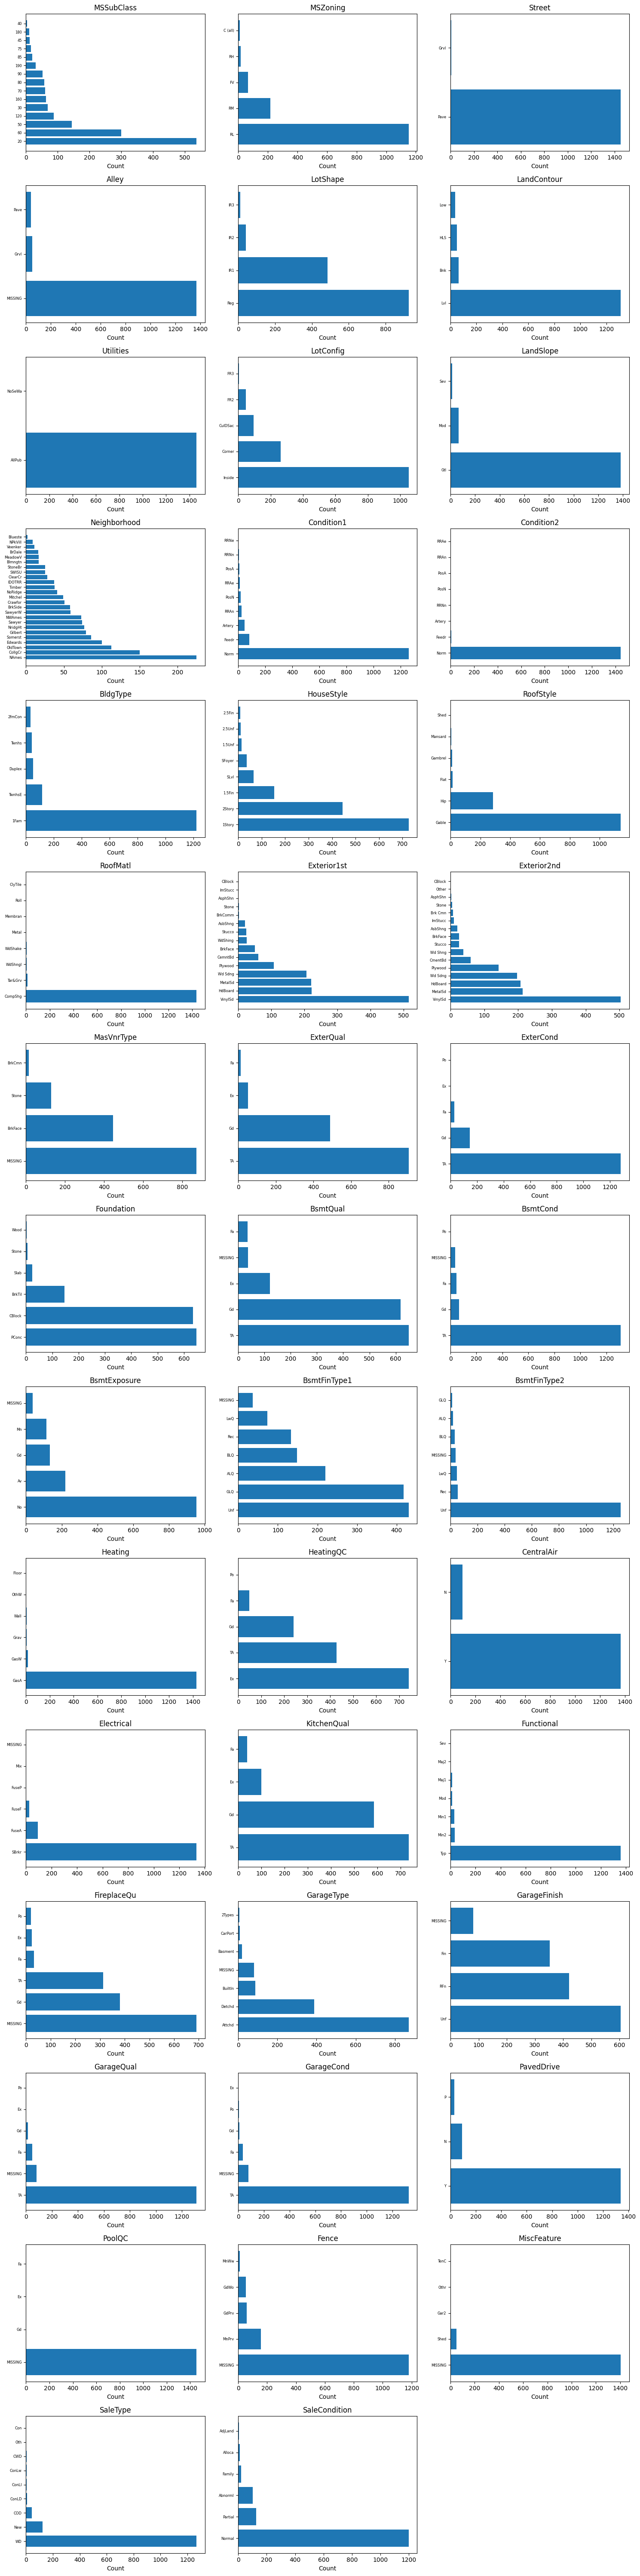

In [33]:
# Identify your categorical columns
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Decide on grid layout
n = len(cat_cols)
cols = 3
rows = math.ceil(n / cols)

# Build subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Loop and draw each bar chart
for ax, col in zip(axes, cat_cols):
    counts = train[col].fillna('MISSING').value_counts()
    ax.barh(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_xlabel('Count')
    ax.tick_params(axis='y', labelsize=6)

# Hide any unused axes
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## House price distribution

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


The figure layout has changed to tight


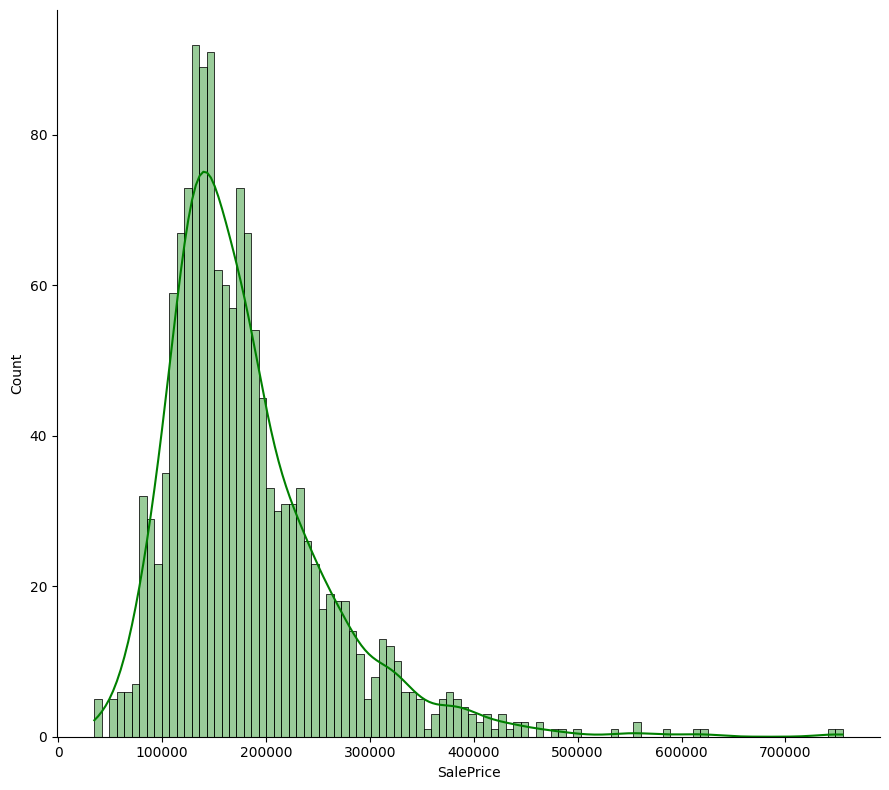

In [11]:
print(train["SalePrice"].describe())

sns.displot(
    data=train,
    x="SalePrice",
    kind="hist",         # you can also use kind="kde" or kind="ecdf"
    bins=100,
    color="g",
    alpha=0.4,
    kde=True,            # only works when kind="hist"
    height=8,
    aspect=9/8           # width = aspect × height
)

## Numeric data distribution

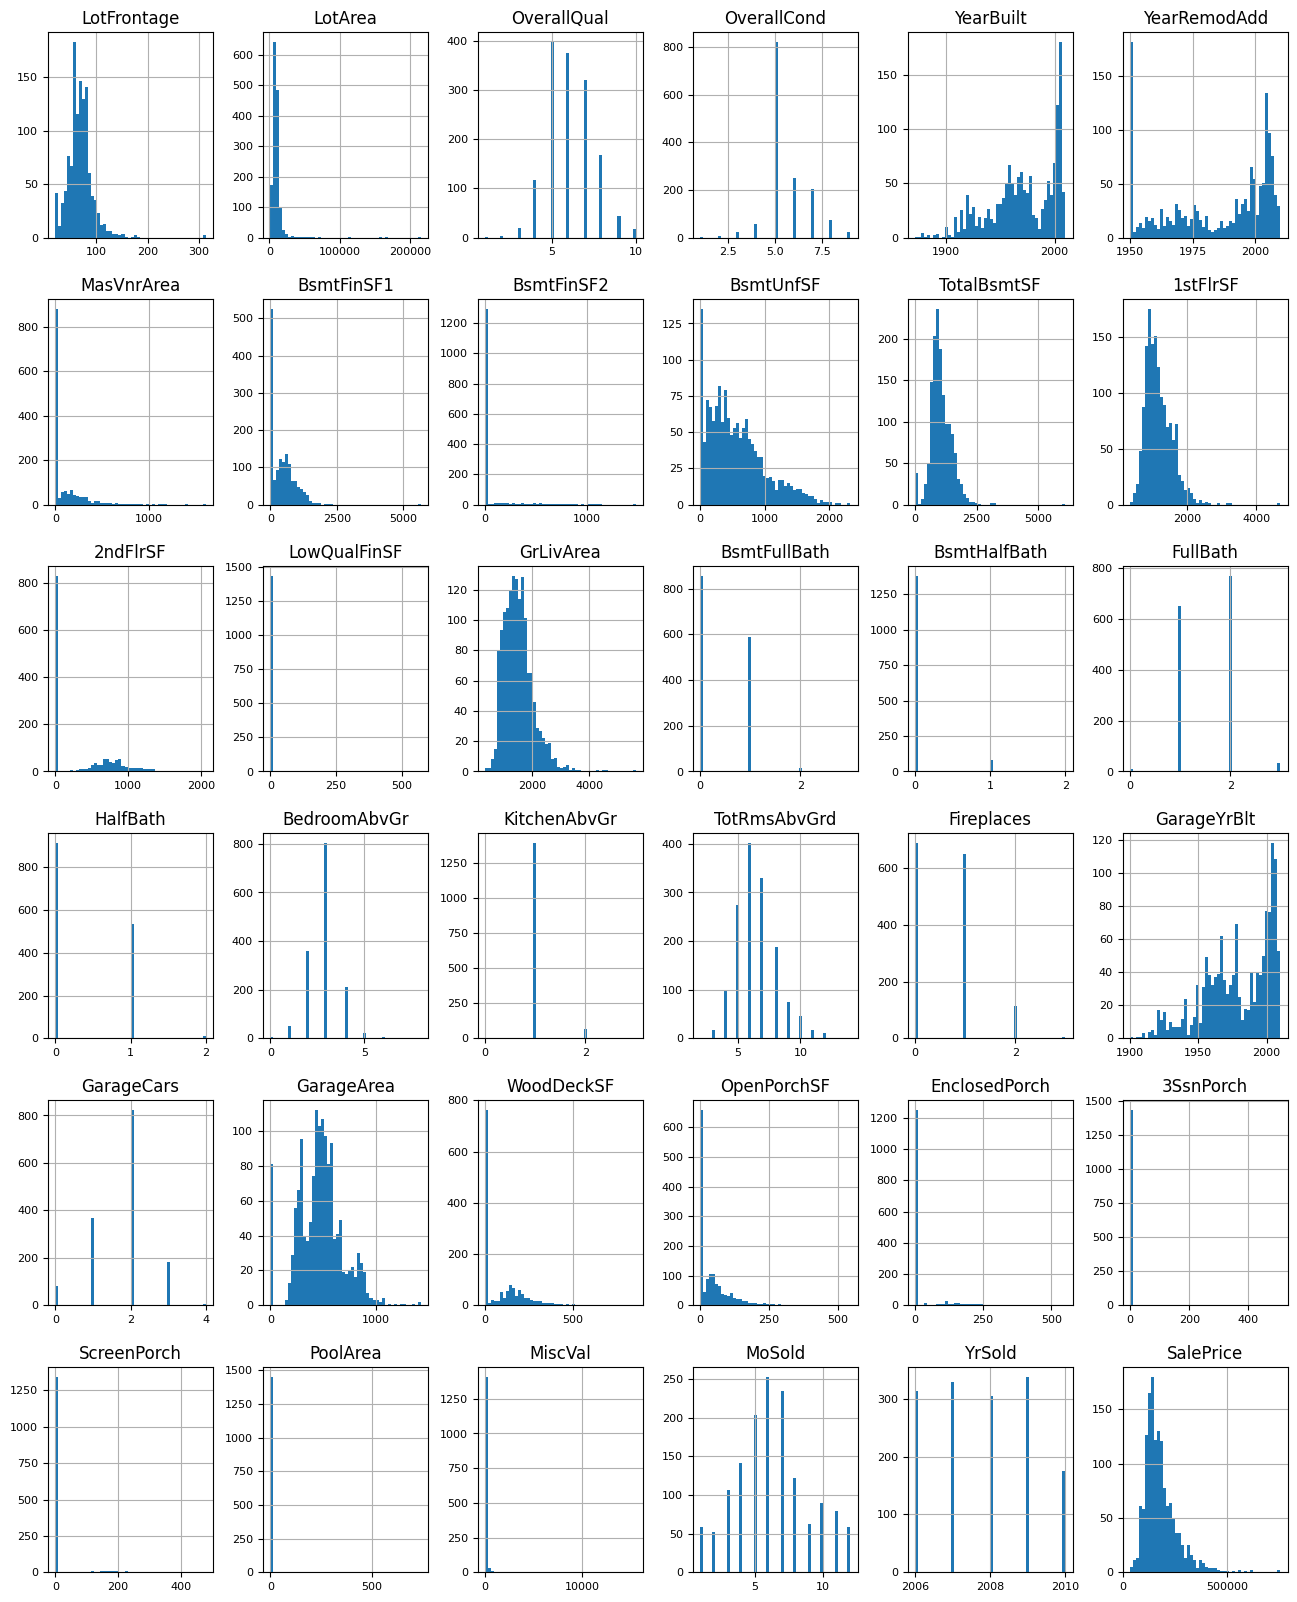

In [12]:
train \
    .select_dtypes(
        include=['float64', 'int64']
    ) \
    .hist(
        figsize=(16, 20),
        bins=50,
        xlabelsize=8,
        ylabelsize=8
    );

# Feature Engineering & Selection

> **Goal:** Transform raw inputs into signal-rich features, and pick the ones most predictive.

* **What** new features can we derive (date-parts, ratios, text embeddings)?
* **How** do we encode categorical variables (one-hot, target encoding, embeddings)?
* **Which** features add real predictive power vs. noise?
* **Should** we apply dimensionality reduction (PCA, LDA) or feature-selection algorithms?

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

## Pipeline

### For linear, YDF tree, and XGBoost models

In [14]:
X_train, X_valid, y_train, y_valid,\
df_train_ydf, df_valid_ydf, preprocessor = make_preprocessor(train)

### For Keras MLP

In [15]:
X_train_mlp, X_valid_mlp, _, _, _, _, _ = make_preprocessor(train, scale_numeric=True)

# Model Training & Tuning

> **Goal:** Fit candidate algorithms and optimize them on your training data.

* **What** modeling families make sense (linear, tree-based, neural nets, clustering)?
* **Which** hyperparameters will we tune, and what search strategy (grid, random, Bayesian)?
* **How** will we split our data (hold-out set, k-fold cross-validation, time series CV)?
* **Are** computation and inference time within acceptable limits?

## Model selection

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

## Linear Models

### Unregularized linear regression / ordinary least squares

In [16]:
if IS_INTERACTIVE:
    lr = LinearRegression(fit_intercept=True, n_jobs=-1)
    lr.fit(X_train, y_train)

### Ridge (Grid via RidgeCV)

In [17]:
if IS_INTERACTIVE:
    ridge_alphas = np.logspace(-3, 3, 13)
    ridge = RidgeCV(alphas=ridge_alphas, store_cv_values=True)
    ridge.fit(X_train, y_train)
    print("Ridge     α* =", ridge.alpha_)

Ridge     α* = 10.0


### Lasso (built-in LassoCV)

In [18]:
if IS_INTERACTIVE:
    lasso_alphas = np.logspace(-4, 0, 50)
    lasso = LassoCV(alphas=lasso_alphas, cv=5, n_jobs=-1, max_iter=5000)
    lasso.fit(X_train, y_train)
    print("Lasso     α* =", lasso.alpha_)

Lasso     α* = 0.0007906043210907702


### ElasticNet (ElasticNetCV)

In [19]:
if IS_INTERACTIVE:
    en_alpha    = np.logspace(-4, 0, 30)
    en_l1_ratio = np.linspace(0.1, 0.9, 9)
    enet = ElasticNetCV(
        alphas=en_alpha,
        l1_ratio=en_l1_ratio,
        cv=5,
        n_jobs=-1,
        max_iter=5000
    )
    enet.fit(X_train, y_train)
    print("ElasticNet α*, l1_ratio* =", enet.alpha_, enet.l1_ratio_)

ElasticNet α*, l1_ratio* = 0.0032903445623126675 0.1


## Tree-based models

### Classification and regression trees (CART) - Single Decision Tree

In [ ]:
if IS_INTERACTIVE:
    # Define the full grid
    cart_search_space = {
        "max_depth":    [3, 5, 10, 15, None],
        "min_examples": [1, 5, 10, 20],
    }
    cart_sampler = GridSampler(cart_search_space)
    study_cart = optuna.create_study(
        direction="minimize",
        sampler=cart_sampler
    )
    cart_obj = make_cart_objective(df_train_ydf, df_valid_ydf, y_valid)
    # n_trials = len(max_depth) x len (min_examples) = 5 × 4 = 20
    study_cart.optimize(cart_obj, n_trials=20, show_progress_bar=True)

    print("CART best params:", study_cart.best_params)

  0%|          | 0/20 [00:00<?, ?it/s]

CART best params: {'max_depth': None, 'min_examples': 10}


### Ensemble methods

#### Bagging

##### Random forest

In [ ]:
if IS_INTERACTIVE:
    rf_sampler = RandomSampler(seed=42)
    study_rf = optuna.create_study(
        direction="minimize",
        sampler=rf_sampler
    )
    rf_obj   = make_rf_objective(  df_train_ydf, df_valid_ydf, y_valid)
    study_rf.optimize(rf_obj, n_trials=50, show_progress_bar=True)

    print("RF    best params:", study_rf.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

RF    best params: {'num_trees': 500, 'max_depth': 30, 'num_candidate_attributes_ratio': 0.7, 'min_examples': 1}


#### Boosting

##### Gradient Boosted Trees

In [ ]:
study_gbts = optuna.create_study(direction="minimize")
gbts_obj = make_gbts_objective(df_train_ydf, df_valid_ydf, y_valid)
study_gbts.optimize(gbts_obj, n_trials=50, show_progress_bar=True)

print("GBT best params:", study_gbts.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

GBT best params: {'num_trees': 565, 'shrinkage': 0.03492912832241257, 'max_depth': 4, 'subsample': 0.587311335089779, 'num_candidate_attributes_ratio': 0.9434805167812443, 'l2_regularization': 3.310827334325542}


##### Extreme gradient boosting (XGBoost)

In [ ]:


if IS_INTERACTIVE:
    study_xgb = optuna.create_study(direction="minimize")
    xgb_obj  = make_xgb_objective(  X_train, X_valid, y_train, y_valid)
    study_xgb.optimize(xgb_obj, n_trials=50, show_progress_bar=True)

    print("XGB best params:", study_xgb.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

XGB best params: {'n_estimators': 488, 'lr': 0.14433228683158172, 'max_depth': 3, 'subsample': 0.6901007486248811, 'colsample_bytree': 0.5793567497270674, 'gamma': 0.011450702590077556, 'reg_alpha': 1.7842588795066383, 'reg_lambda': 8.464149061840303}


## Neural network

Here I will implement a multi-layer perceptron (MLP). I am using Optuna with Hyperband pruning.

In [ ]:
if IS_INTERACTIVE:
    pruner = HyperbandPruner()
    study_mlp = optuna.create_study(direction="minimize", pruner=pruner)
    mlp_obj  = make_mlp_objective(  X_train_mlp, X_valid_mlp, y_train, y_valid)
    study_mlp.optimize(mlp_obj, n_trials=50, show_progress_bar=True)

    print("Best hyperparameters:", study_mlp.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

I0000 00:00:1748122574.586880     162 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13924 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748122574.587518     162 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1748122577.161352   77549 service.cc:148] XLA service 0x7b194c008070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748122577.161963   77549 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748122577.161981   77549 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748122577.341219   77549 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748122578.747882   77549 device_compiler.h:188] Compiled clust

Best hyperparameters: {'n_layers': 1, 'units_l0': 64, 'activation': 'elu', 'dropout': 0.001243907959863108, 'weight_decay': 2.738506081408067e-05, 'batch_norm': False, 'lr': 0.0012052971272268032, 'optimizer': 'adam', 'batch_size': 64, 'lr_schedule': 'reduce_on_plateau', 'patience': 3, 'max_epochs': 200}


# Model Evaluation & Validation

> **Goal:** Rigorously assess performance on unseen data and guard against overfitting.

* **What** evaluation metrics reflect business goals (accuracy, precision/recall, MAE, ROC-AUC)?
* **How** does performance differ between training, validation, and test sets?
* **Do** error patterns reveal biases or weaknesses in specific segments?
* **Have** we stress-tested on edge cases or simulated production conditions?

In [25]:
if IS_INTERACTIVE:
    print("Root Mean Square Error (RMSE) on Validation Dataset:")
    print("Linear.....", mean_squared_error(y_valid, lr.predict(X_valid), squared=False))
    print("Ridge......", mean_squared_error(y_valid, ridge.predict(X_valid), squared=False))
    print("Lasso......", mean_squared_error(y_valid, lasso.predict(X_valid), squared=False))
    print("ElasticNet.", mean_squared_error(y_valid, enet.predict(X_valid), squared=False))
    print("CART.......", study_cart.best_value)
    print("RF.........", study_rf.best_value)
    print("GBT........", study_gbts.best_value)
    print("XGB........", study_xgb.best_value)
    print("MLP........", study_mlp.best_value)

Root Mean Square Error (RMSE) on Validation Dataset:
Linear..... 0.13766379322021527
Ridge...... 0.13737903107931151
Lasso...... 0.13450333387170044
ElasticNet. 0.13612149279947824
CART....... 0.19287085834185905
RF......... 0.1446035681844609
GBT........ 0.13179615663641905
XGB........ 0.14715738528041064
MLP........ 0.14096385968773842


Gradient Boosted Trees (GBT) is the winning model

In [26]:
# Grab the best params
best_params = study_gbts.best_params
print("Best hyperparameters:", best_params)

# Reconstruct & train the final model
final_learner = ydf.GradientBoostedTreesLearner(
    label="SalePrice",
    task=ydf.Task.REGRESSION,
    **best_params
)
final_model = final_learner.train(df_train_ydf)

# Predict on validation (or any) DataFrame
preds_valid = final_model.predict(df_valid_ydf)

# Confirm RMSE on validation set. It should match value before.
rmse = np.sqrt(mean_squared_error(y_valid, preds_valid))
print("Final RMSE on validation set:", rmse)

Best hyperparameters: {'num_trees': 565, 'shrinkage': 0.03492912832241257, 'max_depth': 4, 'subsample': 0.587311335089779, 'num_candidate_attributes_ratio': 0.9434805167812443, 'l2_regularization': 3.310827334325542}
Final RMSE on validation set: 0.13179615663641905


# Interpretation & Communication

> **Goal:** Translate technical findings into actionable insights for stakeholders.

* **What** are the top drivers of model predictions (feature importances, SHAP values)?
* **Which** visualizations (charts, dashboards, interactive apps) will best convey results?
* **What** trade-offs or limitations must decision-makers understand?
* **What** concrete recommendations or next steps arise from our analysis?

## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

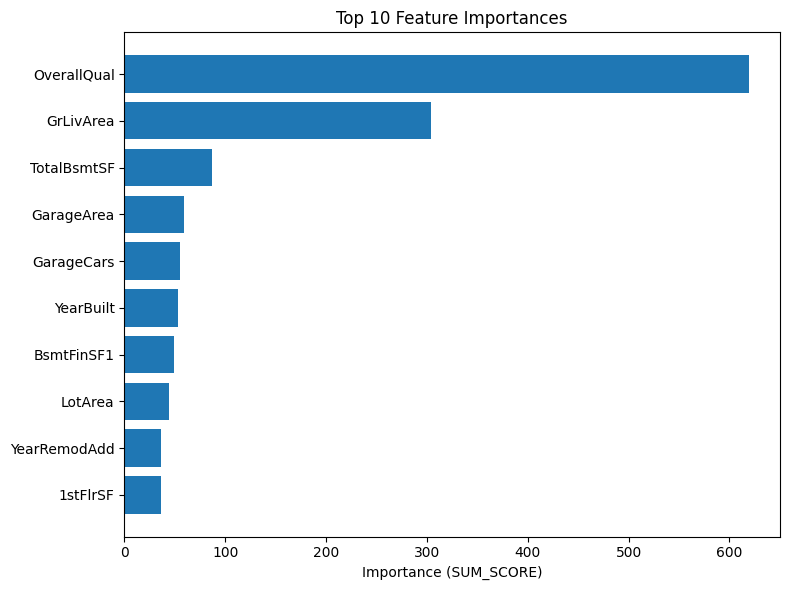

  0%|          | 0/50 [00:00<?, ?it/s]

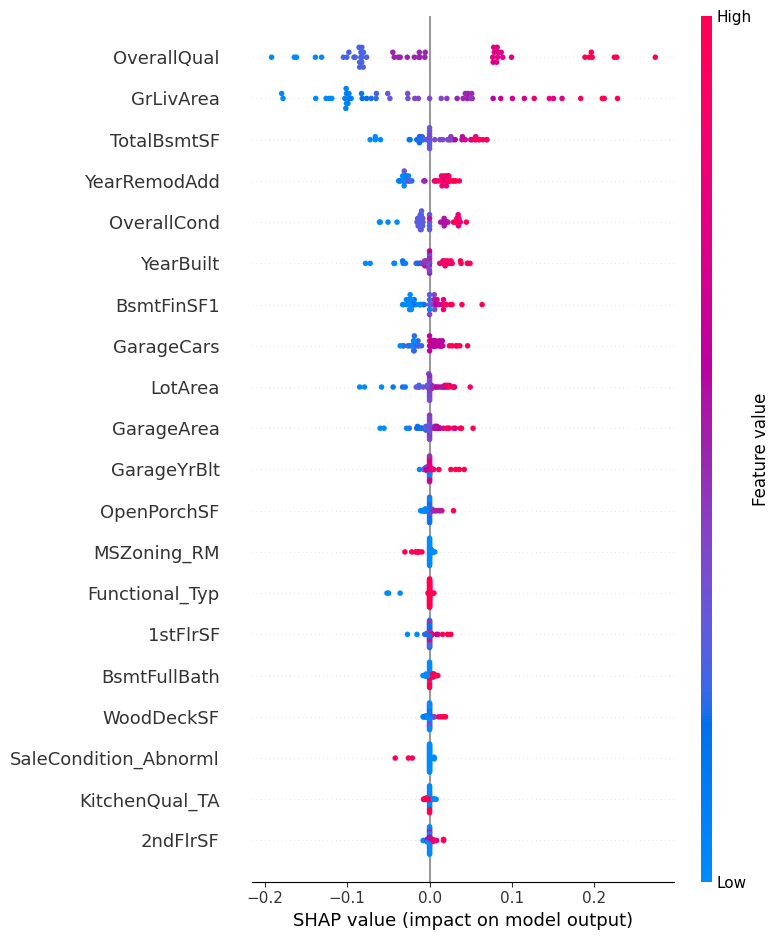

In [27]:
if IS_INTERACTIVE:
    # Global importances
    # 1) Grab the raw (importance, feature) tuples
    importances = final_model.variable_importances()["SUM_SCORE"]
    
    # 2) Turn into a DataFrame for convenience
    df_vi = pd.DataFrame(importances, columns=["importance", "feature"])
    # If feature is a ColumnSpec, extract its name
    df_vi["feature"] = df_vi["feature"].apply(lambda f: getattr(f, "name", f))
    
    # 3) Sort and take top 10
    df_top10 = df_vi.sort_values("importance", ascending=False).head(10)
    
    # 4) Plot as a horizontal bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(df_top10["feature"][::-1], df_top10["importance"][::-1])
    plt.xlabel("Importance (SUM_SCORE)")
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
    
    # SHAP summary plot
    # 1) Prepare feature matrix (no label column)
    X = df_valid_ydf.drop("SalePrice", axis=1)
    
    # 2) Select a small “background” sample to estimate expectations
    #    (too large and KernelExplainer will be *very* slow)
    background = X.sample(100, random_state=42)
    
    # 3) Wrap your model.predict function
    predict_fn = lambda data: final_model.predict(
        pd.DataFrame(data, columns=X.columns)
    )
    
    # 4) Create the explainer
    explainer = shap.KernelExplainer(predict_fn, background)
    
    # 5) Compute approximate Shapley values for a subset
    shap_vals = explainer.shap_values(X.iloc[:50], nsamples=200)
    
    # 6) Plot the summary (beeswarm) for those 50 samples
    shap.summary_plot(shap_vals, X.iloc[:50], feature_names=X.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

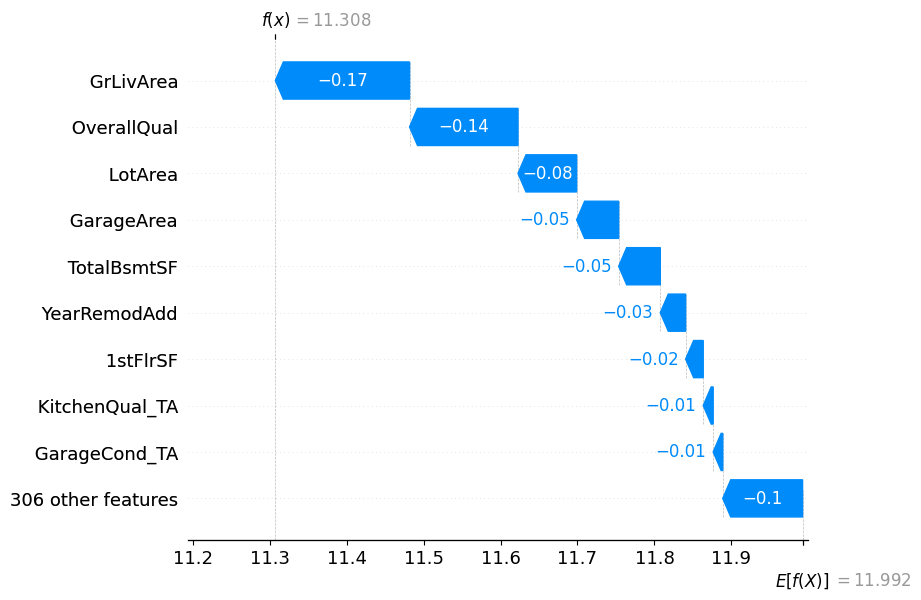

In [28]:
if IS_INTERACTIVE:
    # Choose a single instance index to explain
    idx = 5   # the 6th house in validation set
    x_instance = X.iloc[idx:idx+1]   # keep as DataFrame
    
    # Compute SHAP values for just that one instance
    shap_vals = explainer.shap_values(x_instance, nsamples=200)
    
    # Waterfall plot (static, great for reports)
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_vals[0],
        x_instance.iloc[0],
        max_display=10
    )

# Deployment & Monitoring

> **Goal:** Put the model into production, ensure it runs reliably, and watch for drift.

* **Where** will the model live—batch pipeline, real-time API, embedded in app?
* **What** infrastructure, versioning, and CI/CD processes are needed?
* **How** will we instrument logging, performance metrics, and automated alerts?
* **What** thresholds or drift-detection methods will trigger retraining or rollback?

## Submission

Finally predict on the competition test data using the model.

In [29]:
# Load the raw test set
df_test = pd.read_csv(base_path + "/test.csv")
test_ids = df_test["Id"]

# Preprocess exactly as done training
# Drop the Id column, keep features only
X_test = df_test.drop("Id", axis=1)

# Apply the ColumnTransformer fit earlier
# (this will do median‐impute, one‐hot, etc.)
X_test_prep = preprocessor.transform(X_test)

# Rebuild a DataFrame for YDF, with the same columns used for train
feat_names = preprocessor.get_feature_names_out()
# Remove the "num__" or "cat__" prefix so names match what YDF saw at train time
clean_names = [fn.split("__", 1)[1] for fn in feat_names]
df_test_ydf = pd.DataFrame(X_test_prep, columns=clean_names)

# Predict with your final_model
preds = np.expm1(final_model.predict(df_test_ydf))

# Build and save the submission file
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": preds
})
submission.to_csv("submission.csv", index=False)
print("Wrote submission.csv with", len(submission), "rows.")

Wrote submission.csv with 1459 rows.


# Reflection & Continuous Improvement

> **Goal:** Capture lessons learned, evolve the solution, and plan for future cycles.

* **What** went well vs. what bottlenecks emerged in the workflow?
* **How** could we automate or streamline repetitive steps?
* **Which** additional data sources or techniques might boost performance?
* **What** documentation and hand-offs are needed for long-term maintainability?